In [91]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
from gridworld_env_assignment import GridWorld
from utils import paint_gridworld

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Checking the initial environments.
Construct a `GridWorld` with appropriate input arguments for each of the two tasks. Use `paint_gridworld` to plot the resulting environments. 

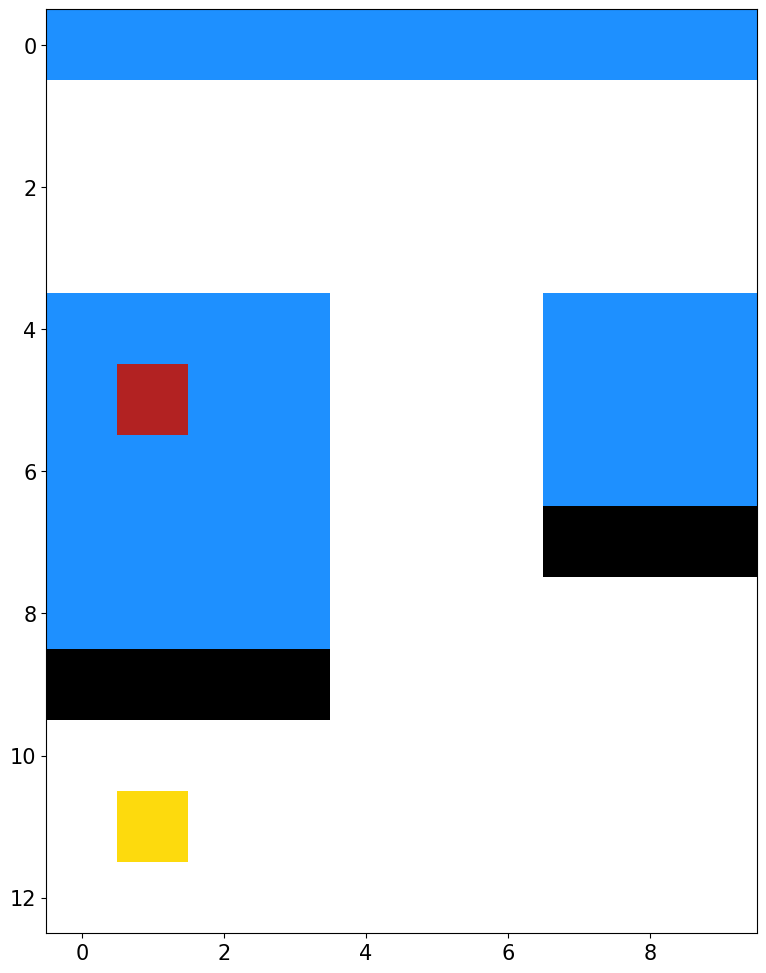

In [192]:
example_env = GridWorld(goal_locations=[(5,1)], goal_rewards=[100])


paint_gridworld(example_env)

## Example of running a simulation 

In [ ]:
number_of_actions = example_env.get_action_size()

reward_lst = []

# Reset the environment to start from the starting location. 
# The reset() method returns the state, reward, and whether the episode is done or not
# More information can be found under the definition of the method
_, state, reward, done = example_env.reset()
reward_lst.append(reward)

# Track the most recent action from each state. 
# This can make a nice visualization. 
most_recent_action_from_state = np.ones(example_env.get_gridshape()) * -1

# Repeat until the episode is not done, i.e. the agent has not fallen into a cliff,
# the maximum length of the episode has not been exceeded, and the target has not been reached.
while not done:
    # Take a step using the step() function and passing in one of the available actions [0, 1, 2, 3] 
    # corresponding to ['N', 'S', 'E', 'W']
    # More information can be found under the definition of the method
    # In this very simple example for each step we choose a random action
    action_from_state = np.random.choice(number_of_actions)

    state_as_tuple = example_env.get_loc_from_state(state)
    most_recent_action_from_state[state_as_tuple] = action_from_state

    _, state, reward, done = example_env.step(action_from_state)
    reward_lst.append(reward)

print(f'Collected rewards of an episode: {reward_lst}')
paint_gridworld(example_env, actions=most_recent_action_from_state)

# Create an RL Agent

Implement either SARSA or Q-learning to determine how your agent executes actions and learns from the gathered rewards.

In [185]:
def soft_max_policy(Q, state, tau):
    q_values = Q[state]
    q_values = q_values - np.max(q_values)
    exp_Q = np.exp(q_values / tau)
    sum_exp_Q = np.sum(exp_Q)
    probabilities = exp_Q / sum_exp_Q
    return np.random.choice(len(q_values), p=probabilities)

def find_dist(loc1, loc2):
    """Simple distance between two (row, col) points."""
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

def learn_policy(env: GridWorld, Q, n_episodes, initial_lr, gamma,initial_tau) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using Q-Learning.

    Args:
        env: The grid-world environment.
        Q: Q-table
        n_episodes: Number of episodes to run learning.
        initial_lr: Learning rate.
        gamma: Discount factor.
        initial_tau:Starting temperature for softmax. 

    Returns:
        policy: A 2D array of shape (env.height, env.width), with the best action (0-3) for each state.
        total_rewards: List of total rewards collected in each episode.
        episode_lengths: List of number of steps taken per episode.
    """
    height, width = env._shape
    total_rewards = []
    episode_lengths = []
    BIG_REWARD_LOCATION = env._goal_loc[0]

    for episode in range(n_episodes):
        tau = max(0.01, initial_tau * (0.995 ** episode))  # Annealing temperature
        lr = max(0.1, initial_lr * (0.999 ** episode)) #annealing tau
        total_reward = 0
        steps = 0
        _, state, _, _ = env.reset() 
        current_position = env._locations[state]
        current_distance = find_dist(current_position, BIG_REWARD_LOCATION)
        action = soft_max_policy(Q, state, tau)
        done = False

        while not done:
            _, next_state, reward, done = env.step(action)
            next_position = env._locations[next_state]
            next_distance = find_dist(next_position, BIG_REWARD_LOCATION)
        
            if next_distance < current_distance:
                reward += 1  
            elif next_distance > current_distance:
                reward -= 50  
      

            if not done:
                target = np.max(Q[next_state])
                Q[state][action] += lr * (reward + gamma * target - Q[state][action])
                state = next_state
                action = soft_max_policy(Q, state, tau)
            else:
                 Q[state][action] += lr * (reward- Q[state][action])
                
            total_reward += reward
            steps += 1

        total_rewards.append(total_reward)
        episode_lengths.append(steps)

    
    policy = np.argmax(Q, axis=1)

    return policy, total_rewards, episode_lengths


# Learn Policy for Dual Targets with Differing Rewards
Learn a policy for an environment with two goals, where the more distant goal is considerably more valuable. 

TIP: Test the learning algorithm with an environment that has just a single reward, and in different positions. 

TIP: Modify the relative rewards between the two goals to see changes in behavior. 

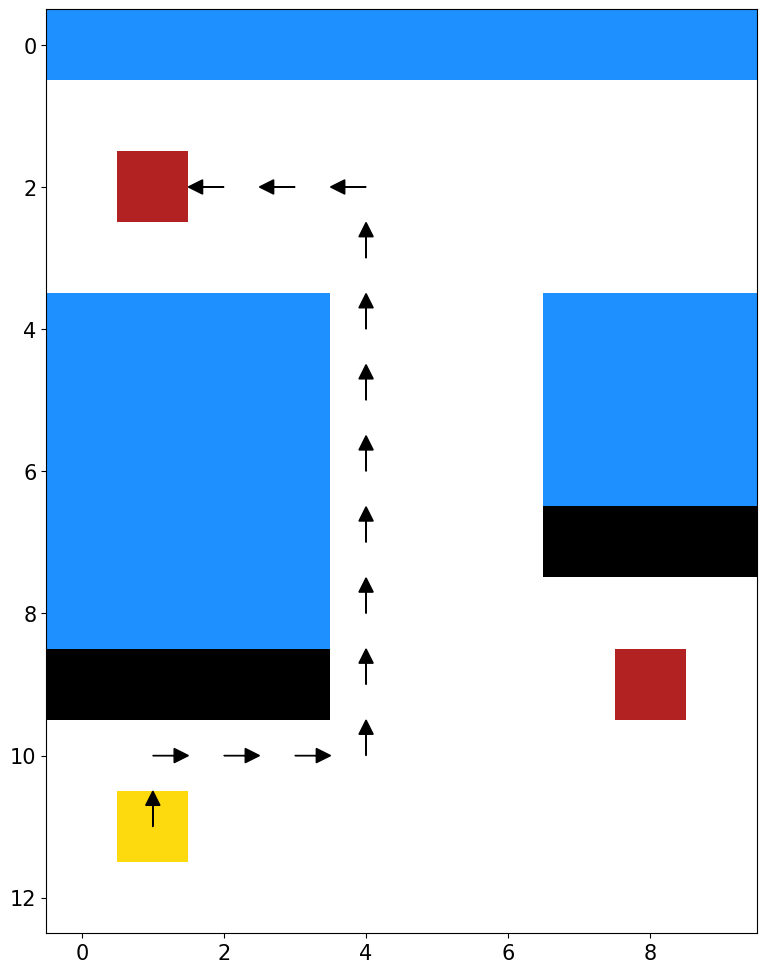

In [190]:
env = GridWorld(goal_locations=[(2,1),(9,8)], goal_rewards=[5000, 250])
Q = np.zeros((env.get_state_size(), env.get_action_size())) 
TAU = 0.9          
GAMMA =0.99       
LEARNING_RATE = 0.5 
N_EPISODES = 10000   

policy, total_rewards, total_steps = learn_policy(env, Q, N_EPISODES, LEARNING_RATE, GAMMA,TAU)

number_of_actions = env.get_action_size()

reward_lst = []

# Reset the environment to start from the starting location. 
# The reset() method returns the state, reward, and whether the episode is done or not
# More information can be found under the definition of the method

_, state, reward, done = env.reset()
reward_lst.append(reward)

# Track the most recent action from each state. 
# This can make a nice visualization. 
most_recent_action_from_state = np.ones(env.get_gridshape()) * -1

# Repeat until the episode is not done, i.e. the agent has not fallen into a cliff,
# the maximum length of the episode has not been exceeded, and the target has not been reached.
while not done:
    # Take a step using the step() function and passing in one of the available actions [0, 1, 2, 3] 
    # corresponding to ['N', 'S', 'E', 'W']
    # More information can be found under the definition of the method
    # In this very simple example for each step we choose a random action
    # action_from_state = np.random.choice(number_of_actions)
    
    action_from_state = soft_max_policy(Q, state, TAU)
    state_as_tuple = env.get_loc_from_state(state)
    most_recent_action_from_state[state_as_tuple] = action_from_state

    _, state, reward, done = env.step(action_from_state)
    reward_lst.append(reward)


paint_gridworld(env, actions=most_recent_action_from_state)

⏳ Estimated time to complete 500 runs: 6523.82 seconds (~108.73 minutes)


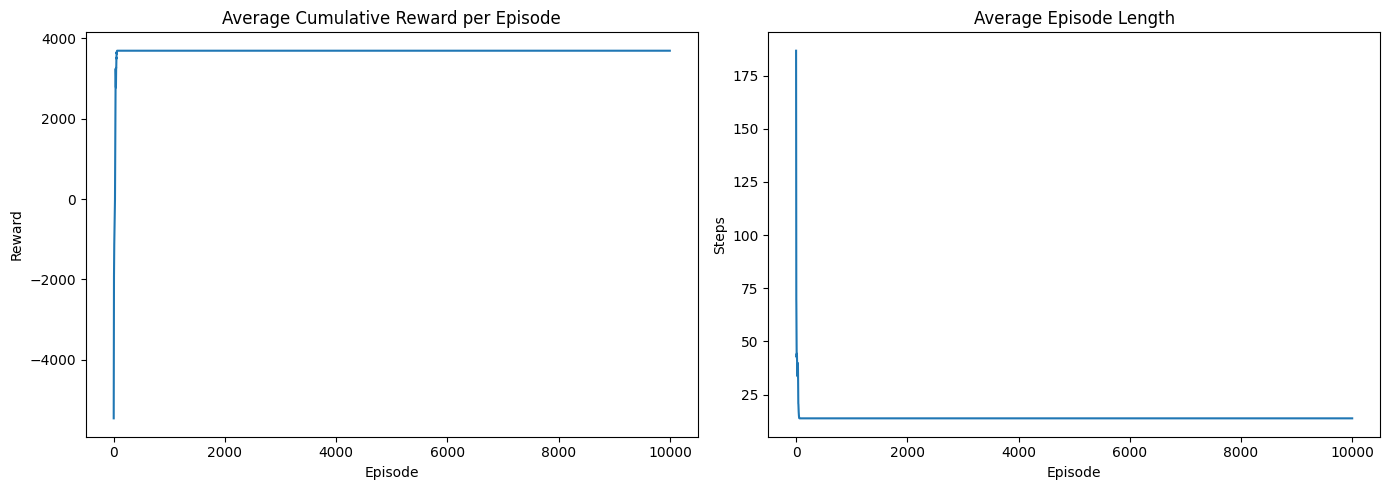

In [191]:
def average_learning(env, n_runs, n_episodes):
    all_rewards = []
    all_lengths = []

    test_runs = 3
    start_time = time.time()
    for _ in range(test_runs):
        Q = np.zeros((env.get_state_size(), env.get_action_size()))
        learn_policy(env, Q, n_episodes, LEARNING_RATE, GAMMA, TAU)
    elapsed = time.time() - start_time
    avg_time_per_run = elapsed / test_runs
    estimated_total = avg_time_per_run * n_runs
    print(f" Estimated time to complete {n_runs} runs: {estimated_total:.2f} seconds (~{estimated_total/60:.2f} minutes)")

    # Run the actual full learning loop
    for run in range(n_runs):
        Q = np.zeros((env.get_state_size(), env.get_action_size()))
        policy, total_rewards, total_steps = learn_policy(env, Q, n_episodes, LEARNING_RATE, GAMMA, TAU)
        all_rewards.append(total_rewards)
        all_lengths.append(total_steps)

    # Compute averages
    avg_rewards = np.mean(all_rewards, axis=0)
    avg_lengths = np.mean(all_lengths, axis=0)

    # Plotting
    episodes = np.arange(n_episodes)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episodes, avg_rewards)
    plt.title('Average Cumulative Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(1, 2, 2)
    plt.plot(episodes, avg_lengths)
    plt.title('Average Episode Length')
    plt.xlabel('Episode')
    plt.ylabel('Steps')

    plt.tight_layout()
    plt.show()

    return avg_rewards, avg_lengths

N_RUN= 500
avg_rewards, avg_lengths = average_learning(env,N_RUN,N_EPISODES)
